In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np 
import random
import time 
import os

torch.backends.cudnn.deterministic = True 
torch.backends.cudnn.benchmark = False

transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4), 
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ])


transform_test = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ]) 



train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100) 

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified



# function

In [6]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) 
        self.fc = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

def train(model, data_loader, criterion, optimizer, n_epoch):
    model.train()
    for epoch in range(n_epoch):
        running_loss = 0
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.cuda(), labels.cuda()
            model_outputs = model(images)

            loss = criterion(input=model_outputs, target=labels)
            running_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch {}, loss = {:.2f}'.format(epoch + 1, running_loss/len(data_loader)))

def eval(model, data_loader):
    model.eval()
    total = 0
    correct = 0
    i = 3
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.cuda(), labels.cuda()

            model_outputs = model(images)
            _, predicted = torch.max(model_outputs, 1)

            total += labels.size(0)
            correct += (predicted==labels).sum().item()
            if i > 0:
              i = i - 1
              print(images.shape)
              img = images.cpu().numpy()
              plt.imshow(np.transpose(img[0], (1, 2, 0)))
              plt.show()

        accuracy = 100 * correct / total

    print('Test Accuracy: {}%'.format(accuracy))


# no batchnorm

In [8]:
reset_seed(0)
criterion = nn.CrossEntropyLoss()
vgg_model = VGG().to("cuda")
optimizer = optim.Adam(params=vgg_model.parameters())

# train

In [9]:
train(vgg_model, train_loader, criterion, optimizer, n_epoch=10)

Epoch 1, loss = 1.78
Epoch 2, loss = 1.37
Epoch 3, loss = 1.15
Epoch 4, loss = 1.01
Epoch 5, loss = 0.91
Epoch 6, loss = 0.83
Epoch 7, loss = 0.78
Epoch 8, loss = 0.73
Epoch 9, loss = 0.68
Epoch 10, loss = 0.65


# evaluate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


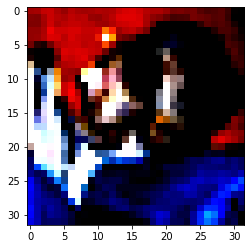

torch.Size([100, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


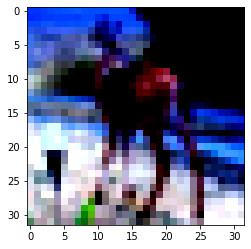

torch.Size([100, 3, 32, 32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


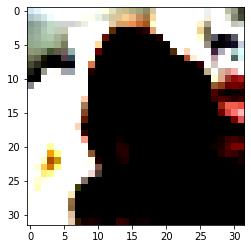

Test Accuracy: 76.63%


In [10]:
eval(vgg_model, test_loader)

# batchnorm implementation

In [14]:
class BatchNorm2d(nn.Module):
    def __init__(self, output_num_channel):
        super(BatchNorm2d, self).__init__()
        self.gamma = nn.Parameter(torch.ones(1, output_num_channel, 1, 1)) 
        self.beta = nn.Parameter(torch.zeros(1, output_num_channel, 1, 1)) 
        
        self.eps = 1e-8
        self.alpha = 0.1
        self.register_buffer('running_mean', torch.zeros((1, output_num_channel, 1, 1)))
        self.register_buffer('running_var', torch.ones((1, output_num_channel, 1, 1)))
        
    def forward(self, input):
        
        if self.training:         
          
          mean_channel = torch.mean(input, dim=[0,2,3])
          var_channel = torch.var(input, dim=[0,2,3])


          mean_channel = mean_channel.view(1, -1, 1, 1)
          var_channel = var_channel.view(1, -1, 1, 1)


          input_normalized = (input - mean_channel) / torch.sqrt(var_channel + self.eps)
          self.running_mean = self.alpha * mean_channel + (1-self.alpha) * self.running_mean
          self.running_var = self.alpha * var_channel + (1-self.alpha) * self.running_var
          output = self.gamma * input_normalized + self.beta

        else:            
          input_normalized = (input -  self.running_mean) / torch.sqrt(self.running_var + self.eps)
          output = self.gamma * input_normalized + self.beta
        
        return output

class VGG_BatchNorm(nn.Module):
    def __init__(self):
        super(VGG_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) 
        self.norm1 = BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.norm2 = BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.norm3 = BatchNorm2d(64)
        
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.norm4 = BatchNorm2d(64)

        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.norm5 = BatchNorm2d(128)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.norm6 = BatchNorm2d(128)

        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) 
        
        self.fc = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)

        x = self.max_pool(x)

        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)

        x = self.max_pool(x)
        
        x = self.conv5(x)
        x = self.norm5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.relu(x)
        
        x = self.avg_pool(x)
        x = x.view(-1, 128)
        x = self.fc(x)
        return x

In [15]:
reset_seed(0)
criterion = nn.CrossEntropyLoss()
vgg_batchnorm_model = VGG_BatchNorm().to("cuda")
optimizer = optim.Adam(params=vgg_batchnorm_model.parameters())

In [16]:
train(vgg_batchnorm_model, train_loader, criterion, optimizer, n_epoch=10)

Epoch 1, loss = 1.30
Epoch 2, loss = 0.90
Epoch 3, loss = 0.74
Epoch 4, loss = 0.65
Epoch 5, loss = 0.59
Epoch 6, loss = 0.54
Epoch 7, loss = 0.51
Epoch 8, loss = 0.48
Epoch 9, loss = 0.46
Epoch 10, loss = 0.43


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


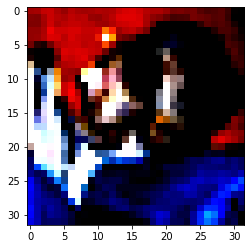

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


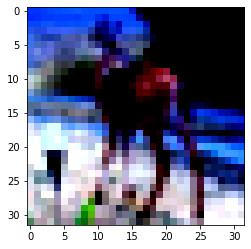

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([100, 3, 32, 32])


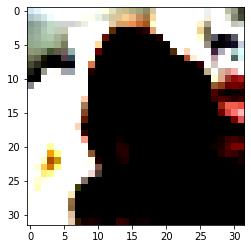

Test Accuracy: 79.84%


In [17]:
eval(vgg_batchnorm_model, test_loader)